# Information Retrieval: From Vector Space to Learning to Rank

**Topics Covered:**
1. Vector Space Model & TF-IDF
2. Cosine Similarity
3. Rocchio Algorithm (Relevance Feedback)
4. k-Nearest Neighbors
5. Evaluation Metrics (Precision, Recall, MAP, nDCG)
6. Learning to Rank: Pointwise, Pairwise, Listwise
7. Key Algorithms: RankSVM, RankNet, LambdaMART

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hsantos10/CSCE-670---Information-Storage-and-Retrieval-Spring-2026-/blob/main/Week%205%3A%20Learning%20to%20Rank.ipynb)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Sample documents
documents = [
    "The cat sat on the mat",
    "The dog sat on the log",
    "Cats and dogs are animals",
    "The animal sat on the chair"
]
query = "cat and dog"

## 1. Vector Space Model & TF-IDF

### Term Frequency (TF)
$$TF(t, d) = \text{count of term } t \text{ in document } d$$

### Inverse Document Frequency (IDF)
$$IDF(t) = \log\frac{N}{df(t)}$$
- $N$ = total documents
- $df(t)$ = documents containing term $t$

### TF-IDF Weight
$$w(t,d) = TF(t,d) \times IDF(t)$$

**Intuition:** High weight = term is frequent in this doc but rare overall

TF-IDF Matrix:
        and  animal  animals    are    cat   cats  chair    dog   dogs    log  \
Doc1  0.000   0.000    0.000  0.000  0.474  0.000  0.000  0.000  0.000  0.000   
Doc2  0.000   0.000    0.000  0.000  0.000  0.000  0.000  0.474  0.000  0.474   
Doc3  0.447   0.000    0.447  0.447  0.000  0.447  0.000  0.000  0.447  0.000   
Doc4  0.000   0.474    0.000  0.000  0.000  0.000  0.474  0.000  0.000  0.000   

        mat     on    sat    the  
Doc1  0.474  0.303  0.303  0.606  
Doc2  0.000  0.303  0.303  0.606  
Doc3  0.000  0.000  0.000  0.000  
Doc4  0.000  0.303  0.303  0.606  


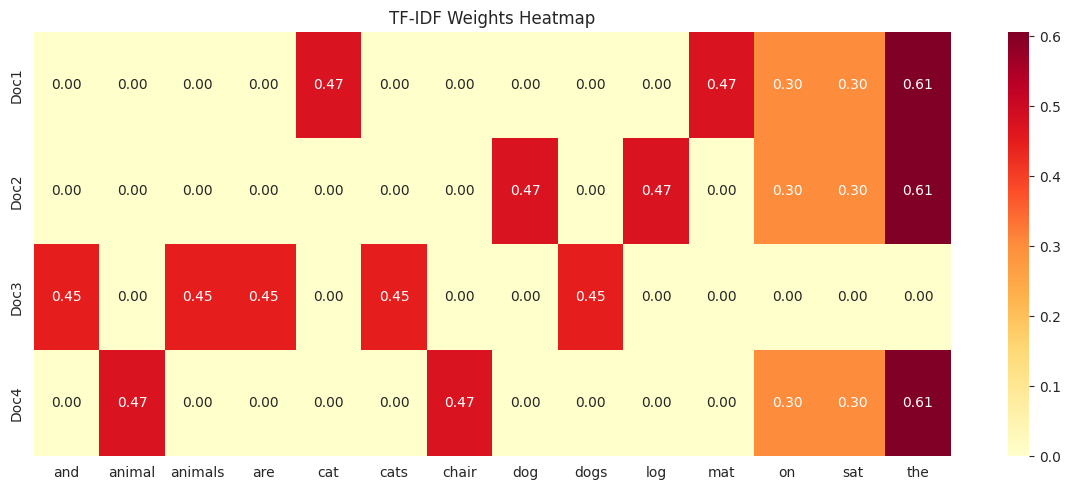

In [ ]:
# Create TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

# Display as DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=feature_names,
    index=[f'Doc{i+1}' for i in range(len(documents))]
)

print("TF-IDF Matrix:")
print(tfidf_df.round(3))

# Visualize
plt.figure(figsize=(12, 5))
sns.heatmap(tfidf_df, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('TF-IDF Weights Heatmap')
plt.tight_layout()
plt.show()

## 2. Cosine Similarity

### Formula
$$\text{sim}(\vec{q}, \vec{d}) = \frac{\vec{q} \cdot \vec{d}}{||\vec{q}|| \cdot ||\vec{d}||} = \frac{\sum q_i d_i}{\sqrt{\sum q_i^2} \sqrt{\sum d_i^2}}$$

**Properties:**
- Range: [0, 1] for text (since weights are non-negative)
- 1 = identical, 0 = orthogonal
- Length-normalized (long docs don't automatically score higher)

Query: 'cat and dog'

Ranked Results:
                   Document  Similarity
     The cat sat on the mat    0.273861
     The dog sat on the log    0.273861
  Cats and dogs are animals    0.258199
The animal sat on the chair    0.000000


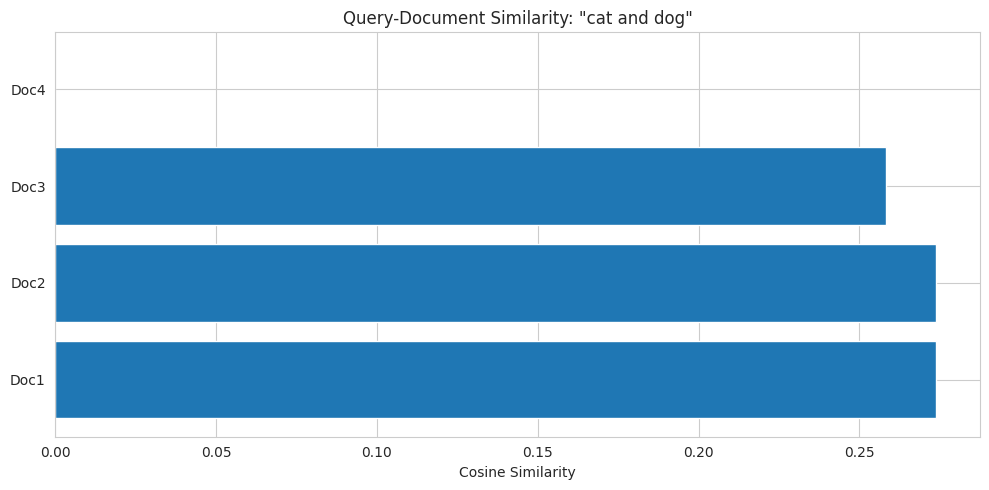

In [ ]:
# Compute similarities
query_vector = vectorizer.transform([query])
similarities = cosine_similarity(query_vector, tfidf_matrix)[0]

# Rank documents
results_df = pd.DataFrame({
    'Document': documents,
    'Similarity': similarities
}).sort_values('Similarity', ascending=False)

print(f"Query: '{query}'\n")
print("Ranked Results:")
print(results_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 5))
plt.barh(range(len(documents)), similarities)
plt.yticks(range(len(documents)), [f'Doc{i+1}' for i in range(len(documents))])
plt.xlabel('Cosine Similarity')
plt.title(f'Query-Document Similarity: "{query}"')
plt.tight_layout()
plt.show()

## 3. Rocchio Algorithm (Relevance Feedback)

### Formula
$$\vec{q}_{new} = \alpha \vec{q}_{old} + \beta \frac{1}{|D_r|} \sum_{\vec{d} \in D_r} \vec{d} - \gamma \frac{1}{|D_{nr}|} \sum_{\vec{d} \in D_{nr}} \vec{d}$$

**Parameters:**
- $\alpha = 1.0$ (original query weight)
- $\beta = 0.75$ (relevant docs weight)
- $\gamma = 0.15$ (non-relevant docs weight)

**Intuition:** Move query towards relevant docs, away from non-relevant

In [ ]:
def rocchio(q_vec, rel_vecs, nonrel_vecs, alpha=1.0, beta=0.75, gamma=0.15):
    """Apply Rocchio algorithm"""
    q = np.array(q_vec)
    centroid_r = np.mean(rel_vecs, axis=0) if len(rel_vecs) > 0 else np.zeros(q.shape)
    centroid_nr = np.mean(nonrel_vecs, axis=0) if len(nonrel_vecs) > 0 else np.zeros(q.shape)
    q_new = alpha * q + beta * centroid_r - gamma * centroid_nr
    q_new[q_new < 0] = 0  # No negative weights
    return q_new

# User feedback: Doc3 relevant, Doc4 non-relevant
relevant_ids = [2]
nonrelevant_ids = [3]

# Apply Rocchio
q_new = rocchio(
    query_vector.toarray(),
    tfidf_matrix[relevant_ids].toarray(),
    tfidf_matrix[nonrelevant_ids].toarray()
)

# Re-rank
new_similarities = cosine_similarity(q_new.reshape(1, -1), tfidf_matrix)[0]

# Compare
comparison = pd.DataFrame({
    'Document': [f'Doc{i+1}' for i in range(len(documents))],
    'Before': similarities,
    'After': new_similarities,
    'Change': new_similarities - similarities
}).sort_values('After', ascending=False)

print("Rocchio Feedback Results:")
print(comparison.round(3).to_string(index=False))
print("\n✅ Doc3 (marked relevant) moved up in ranking!")

Rocchio Feedback Results:
Document  Before  After  Change
    Doc3   0.258  0.722   0.464
    Doc1   0.274  0.196  -0.078
    Doc2   0.274  0.196  -0.078
    Doc4   0.000  0.000   0.000

✅ Doc3 (marked relevant) moved up in ranking!


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# 1. Prepare the data for PCA (Original Query, New Query, and all Docs)
# We flatten q_new because Rocchio returns it as a 2D array usually
q_orig = query_vector.toarray().flatten()
q_revised = q_new.flatten()
all_docs = tfidf_matrix.toarray()

# Combine everything to fit the PCA space
combined_data = np.vstack([all_docs, q_orig, q_revised])

# 2. Reduce to 2D
pca = PCA(n_components=2)
coords = pca.fit_transform(combined_data)

# Extract coordinates
doc_coords = coords[:-2]
q_orig_coord = coords[-2]
q_revised_coord = coords[-1]

# 3. Plotting
plt.figure(figsize=(10, 7))

# Plot All Documents
plt.scatter(doc_coords[:, 0], doc_coords[:, 1], c='lightgrey', label='All Documents', alpha=0.5)

# Highlight Relevant & Non-Relevant feedback
plt.scatter(doc_coords[relevant_ids, 0], doc_coords[relevant_ids, 1],
            c='green', s=100, label='Marked Relevant (Doc 3)', edgecolors='black')
plt.scatter(doc_coords[nonrelevant_ids, 0], doc_coords[nonrelevant_ids, 1],
            c='red', s=100, label='Marked Non-Relevant (Doc 4)', edgecolors='black')

# Plot Queries
plt.scatter(q_orig_coord[0], q_orig_coord[1], c='blue', marker='x', s=100, label='Original Query')
plt.scatter(q_revised_coord[0], q_revised_coord[1], c='darkblue', marker='o', s=100, label='Revised Query')

# Draw the "Movement" Arrow
plt.arrow(q_orig_coord[0], q_orig_coord[1],
          q_revised_coord[0] - q_orig_coord[1],
          q_revised_coord[1] - q_orig_coord[1],
          head_width=0.02, color='blue', linestyle='--', alpha=0.6)

plt.title("Rocchio Query Shift (2D PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

## 4. k-Nearest Neighbors (k-NN)

**Concept:** Retrieve the $k$ most similar documents based on cosine similarity.

This is what standard search does when you ask for "top k results"!

In [ ]:
def knn_search(query, k=2):
    q_vec = vectorizer.transform([query])
    sims = cosine_similarity(q_vec, tfidf_matrix)[0]
    top_k = np.argsort(sims)[::-1][:k]

    print(f"k-NN Search (k={k}):")
    for rank, idx in enumerate(top_k, 1):
        print(f"{rank}. Doc{idx+1} (score={sims[idx]:.3f}): {documents[idx]}")

knn_search(query, k=2)

k-NN Search (k=2):
1. Doc1 (score=0.274): The cat sat on the mat
2. Doc2 (score=0.274): The dog sat on the log


## 5. Evaluation Metrics

### Precision & Recall
$$P = \frac{|\text{Relevant} \cap \text{Retrieved}|}{|\text{Retrieved}|}$$
$$R = \frac{|\text{Relevant} \cap \text{Retrieved}|}{|\text{Relevant}|}$$

### F-Measure
$$F_1 = 2 \cdot \frac{P \cdot R}{P + R}$$

### Average Precision (AP)
$$AP = \frac{1}{|R|} \sum_{k=1}^{n} P(k) \cdot rel(k)$$

### Mean Average Precision (MAP)
$$MAP = \frac{1}{|Q|} \sum_{q=1}^{|Q|} AP(q)$$

### Normalized Discounted Cumulative Gain (nDCG)
$$DCG@k = \sum_{i=1}^{k} \frac{2^{rel_i} - 1}{\log_2(i + 1)}$$
$$nDCG@k = \frac{DCG@k}{IDCG@k}$$

In [ ]:
def precision_recall(retrieved, relevant):
    tp = len(set(retrieved) & set(relevant))
    p = tp / len(retrieved) if retrieved else 0
    r = tp / len(relevant) if relevant else 0
    return p, r

def average_precision(ranked_results, relevant_docs):
    relevant_set = set(relevant_docs)
    precisions = []
    num_relevant = 0

    for i, doc_id in enumerate(ranked_results, 1):
        if doc_id in relevant_set:
            num_relevant += 1
            precisions.append(num_relevant / i)

    return sum(precisions) / len(relevant_set) if relevant_set else 0

def ndcg(relevances, k=None):
    if k: relevances = relevances[:k]
    dcg = sum((2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(relevances))
    ideal = sorted(relevances, reverse=True)
    idcg = sum((2**rel - 1) / np.log2(i + 2) for i, rel in enumerate(ideal))
    return dcg / idcg if idcg > 0 else 0

# Example
retrieved = [3, 7, 1, 5, 2]
relevant = [1, 2, 3, 5]

p, r = precision_recall(retrieved, relevant)
ap = average_precision(retrieved, relevant)

print(f"Retrieved: {retrieved}")
print(f"Relevant:  {relevant}")
print(f"\nPrecision: {p:.3f}")
print(f"Recall:    {r:.3f}")
print(f"F1:        {2*p*r/(p+r):.3f}")
print(f"AP:        {ap:.3f}")

# nDCG example
relevances = [3, 2, 3, 0, 1, 2]  # Graded relevance (0-3)
print(f"\nnDCG@5:    {ndcg(relevances, k=5):.3f}")

## 6. Introduction to Learning to Rank (LTR)

### Evolution
**Before:** Manual weights
```
score = 0.5×TF-IDF + 0.3×PageRank + 0.2×URLDepth
```

**After:** Machine Learning
```
Learn weights w from training data:
score = w₁×TF-IDF + w₂×PageRank + w₃×URLDepth + ...
```

### Training Data Sources
- **Explicit:** Human relevance judgments (0-4 scale)
- **Implicit:** Clickthrough logs (clicked = more relevant)

### Why LTR?
✅ Handles 100+ features automatically  
✅ Learns from user behavior  
✅ Outperforms manual tuning  
✅ Enables personalization

## 7. Three Approaches to LTR

### Pointwise: Predict Relevance Score
- **Input:** Features of (query, doc)
- **Output:** Relevance score (e.g., 0-4)
- **Method:** Regression or classification
- **Example:** Linear regression, neural network

### Pairwise: Predict Relative Order
- **Input:** Features of (query, doc₁, doc₂)
- **Output:** Which doc should rank higher?
- **Method:** Classification on pairs
- **Example:** RankSVM, RankNet, LambdaRank

### Listwise: Optimize Entire Ranking
- **Input:** Features of (query, [doc₁, doc₂, ..., docₙ])
- **Output:** Optimal ordering
- **Method:** Directly optimize IR metric
- **Example:** ListNet, AdaRank

In [ ]:
# Comparison visualization
approaches = ['Pointwise', 'Pairwise', 'Listwise']
metrics = {
    'Simplicity': [9, 6, 3],
    'Performance': [6, 8, 9],
    'Training Speed': [9, 6, 3],
    'Direct Optimization': [3, 6, 9]
}

df = pd.DataFrame(metrics, index=approaches)

fig, ax = plt.subplots(figsize=(10, 6))
df.plot(kind='bar', ax=ax)
ax.set_ylabel('Score (0-10)')
ax.set_title('Comparison of LTR Approaches')
ax.set_xticklabels(approaches, rotation=0)
ax.legend(title='Aspect')
plt.tight_layout()
plt.show()

## 8. Pointwise Approach

### Classification: Binary Relevance
$$y = f(\vec{x}) \in \{0, 1\}$$

### Regression: Graded Relevance
$$y = f(\vec{x}) \in [0, 4]$$

**Pros:** Simple, uses standard ML algorithms  
**Cons:** Doesn't optimize for ranking, treats docs independently

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Features: [tfidf, bm25, pagerank, doc_len, query_coverage]
X_train = np.array([
    [0.9, 0.95, 0.8, 130, 1.0],
    [0.8, 0.85, 0.7, 110, 0.9],
    [0.5, 0.6, 0.4, 80, 0.5],
    [0.3, 0.4, 0.2, 60, 0.3],
    [0.1, 0.15, 0.05, 30, 0.1],
])
y_train = np.array([4, 3, 2, 1, 0])  # Relevance grades

# Train pointwise model
model = RandomForestRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Test
X_test = np.array([
    [0.85, 0.88, 0.75, 115, 0.92],
    [0.4, 0.5, 0.3, 70, 0.4],
    [0.92, 0.96, 0.85, 135, 0.98],
])

predictions = model.predict(X_test)
print("Pointwise Predictions (Relevance Scores):")
for i, score in enumerate(predictions, 1):
    print(f"Doc {i}: {score:.2f}")

# Rank by score
ranked = np.argsort(predictions)[::-1]
print("\nRanking:", [f"Doc{i+1}" for i in ranked])

## 9. Pairwise Approach: RankSVM

### Key Idea
Learn from preference pairs: $(d_i, d_j)$ where $d_i \succ d_j$

### Optimization
$$\min_{\vec{w}} \frac{1}{2}||\vec{w}||^2 + C\sum_{(i,j)} \xi_{ij}$$

Subject to:
$$\vec{w} \cdot (\vec{x_i} - \vec{x_j}) \geq 1 - \xi_{ij}$$

**Intuition:** Learn weight vector $\vec{w}$ such that more relevant docs score higher

### Training Data from Clicks
If user clicks doc at position 5 but not position 2:
$$d_5 \succ d_2 \text{ (generate training pair)}$$

In [ ]:
# Create pairwise training data
def create_pairs(X, y):
    """Generate preference pairs from pointwise data"""
    pairs_X, pairs_y = [], []
    for i in range(len(X)):
        for j in range(len(X)):
            if y[i] > y[j]:
                pairs_X.append(X[i] - X[j])
                pairs_y.append(1)
    return np.array(pairs_X), np.array(pairs_y)

X_pairs, y_pairs = create_pairs(X_train, y_train)
print(f"Generated {len(X_pairs)} preference pairs from {len(X_train)} documents")
print(f"Example pair (difference vector): {X_pairs[0]}")

# Train SVM on pairs
from sklearn.svm import LinearSVC
ranksvm = LinearSVC(random_state=42)
ranksvm.fit(X_pairs, y_pairs)
print("\n✅ RankSVM trained on pairwise preferences")

## 10. Pairwise Approach: RankNet

### Neural Network Architecture
```
Input (features) → Hidden Layers → Output (score)
```

### Pairwise Probability
$$P(d_i \succ d_j) = \frac{1}{1 + e^{-\sigma(s_i - s_j)}}$$

Where $s_i = f_{NN}(\vec{x_i})$ is the neural network score

### Loss Function (Cross-Entropy)
$$L = -\bar{P}_{ij}\log P_{ij} - (1-\bar{P}_{ij})\log(1 - P_{ij})$$

**Training:** Use gradient descent to minimize loss over all pairs

**Advantage:** Smooth, differentiable, scalable to large datasets

In [ ]:
# RankNet probability calculation
def ranknet_prob(score_i, score_j, sigma=1.0):
    return 1.0 / (1.0 + np.exp(-sigma * (score_i - score_j)))

# Example scores
scores = [0.9, 0.7, 0.5, 0.2]

print("RankNet Pairwise Probabilities P(i > j):\n")
print("     " + "  ".join([f"D{i+1}" for i in range(len(scores))]))
for i in range(len(scores)):
    row = f"D{i+1}  "
    for j in range(len(scores)):
        if i == j:
            row += " -   "
        else:
            prob = ranknet_prob(scores[i], scores[j])
            row += f"{prob:.2f} "
    print(row)

print("\nInterpretation: P(D1 > D4) = 0.99 (very confident D1 should rank higher)")

## 11. LambdaRank & LambdaMART

### Problem with RankNet
All pairwise errors weighted equally, but **top-of-ranking errors matter more!**

### LambdaRank Solution
Scale gradients by change in IR metric:

$$\lambda_{ij} = \frac{\partial L}{\partial s_i} \cdot |\Delta nDCG_{ij}|$$

Where $\Delta nDCG_{ij}$ = change in nDCG if we swap docs $i$ and $j$

### LambdaMART
**Combines:** LambdaRank + Gradient Boosted Trees (MART)

**Architecture:**
- Ensemble of decision trees
- Each tree trained on lambda gradients
- Final score = $\sum_t \text{tree}_t(\vec{x})$

**Performance:** Winner of Yahoo! LTR Challenge 2010, industry standard

In [ ]:
# Demonstrate impact of ranking position on nDCG
def show_position_importance():
    base_relevance = [3, 2, 1, 1, 0, 0, 0]

    # Swap highly relevant doc from position 1 to 3
    swap_early = base_relevance.copy()
    swap_early[0], swap_early[2] = swap_early[2], swap_early[0]

    # Swap low relevant doc from position 5 to 7
    swap_late = base_relevance.copy()
    swap_late[4], swap_late[6] = swap_late[6], swap_late[4]

    ndcg_base = ndcg(base_relevance)
    ndcg_early = ndcg(swap_early)
    ndcg_late = ndcg(swap_late)

    print("Impact of Ranking Position on nDCG:\n")
    print(f"Original ranking:     nDCG = {ndcg_base:.3f}")
    print(f"Swap positions 1↔3:   nDCG = {ndcg_early:.3f} (Δ = {ndcg_early-ndcg_base:.3f})")
    print(f"Swap positions 5↔7:   nDCG = {ndcg_late:.3f} (Δ = {ndcg_late-ndcg_base:.3f})")
    print("\n📌 Top-position errors hurt nDCG more → LambdaRank focuses there!")

show_position_importance()

## 12. Comparison & Best Practices

### Algorithm Comparison

| Algorithm | Type | Pros | Cons | Use Case |
|-----------|------|------|------|----------|
| **Linear Regression** | Pointwise | Simple | Doesn't optimize ranking | Baseline |
| **RankSVM** | Pairwise | Good with clicks | Many pairs | Clickthrough data |
| **RankNet** | Pairwise | Scalable | Doesn't prioritize top | Large-scale |
| **LambdaRank** | Pairwise | Direct metric opt. | Complex | High performance |
| **LambdaMART** | Pairwise | State-of-art | Training time | Production |

### Feature Engineering Tips
**Query-Doc Features:** TF-IDF, BM25, cosine similarity  
**Doc Features:** PageRank, length, freshness, authority  
**Query Features:** Length, type, popularity  
**URL Features:** Depth, domain authority, HTTPS  

### Public Datasets
- **LETOR:** Microsoft Research benchmark (MQ2007, MQ2008)
- **MSLR-WEB:** Large-scale Bing data (10K-30K queries)
- **Yahoo! C14:** 30K queries, 700+ features
- **Yandex:** Personalized search data

In [ ]:
# Summary visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Timeline
years = [2002, 2005, 2006, 2010, 2015, 2020]
algorithms = ['RankSVM', 'RankNet', 'LambdaRank', 'LambdaMART', 'Neural LTR', 'BERT Rankers']
ax1.plot(years, range(len(years)), 'o-', linewidth=2, markersize=10)
for i, (year, algo) in enumerate(zip(years, algorithms)):
    ax1.text(year, i, f' {algo}', va='center', fontsize=10)
ax1.set_xlabel('Year')
ax1.set_title('Evolution of Learning to Rank')
ax1.set_yticks([])
ax1.grid(axis='x', alpha=0.3)

# Performance vs Complexity
complexity = [3, 5, 7, 8, 6, 9]
performance = [6, 7, 8, 9, 8, 9.5]
colors = plt.cm.viridis(np.linspace(0, 1, len(algorithms)))

for i, (c, p, algo, col) in enumerate(zip(complexity, performance, algorithms, colors)):
    ax2.scatter(c, p, s=200, color=col, alpha=0.7)
    ax2.annotate(algo, (c, p), fontsize=8, ha='center')

ax2.set_xlabel('Complexity')
ax2.set_ylabel('Performance')
ax2.set_title('Performance vs Complexity Trade-off')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Key Takeaways

### Classical IR
✅ **TF-IDF:** Balance term frequency with document frequency  
✅ **Cosine Similarity:** Length-normalized vector similarity  
✅ **Rocchio:** Query refinement using relevance feedback  

### Evaluation
✅ **Precision/Recall:** Basic quality measures  
✅ **MAP:** Average precision across queries  
✅ **nDCG:** Considers position + graded relevance  

### Learning to Rank
✅ **Pointwise:** Predict individual scores (simple but suboptimal)  
✅ **Pairwise:** Learn relative order (industry standard)  
✅ **LambdaMART:** State-of-the-art, used in production  

### Modern Trends (2024)
🔥 **Transformer Models:** BERT, T5 for semantic matching  
🔥 **Neural Rankers:** End-to-end deep learning  
🔥 **Personalization:** User-specific ranking functions  
🔥 **Multi-task Learning:** Joint optimization of multiple objectives  

---

### References
- Manning et al., "Introduction to Information Retrieval" (2008)
- Liu, "Learning to Rank for Information Retrieval" (2011)
- Burges et al., "Learning to Rank using Gradient Descent" (RankNet, 2005)
- Wu et al., "Adapting Boosting for Information Retrieval" (LambdaMART, 2010)

# Task
Prepare the original query vector, the Rocchio-updated query vector, and the TF-IDF vectors of all documents for plotting by combining them into a single matrix. Then, reduce the dimensionality of this combined matrix to 2 components using PCA. Finally, generate a 2D scatter plot to visualize the original query, the Rocchio-updated query, and each document, using distinct colors and markers to illustrate how the query moves in the vector space after relevance feedback.

## Prepare Vectors for Plotting

### Subtask:
Combine the original query vector, the Rocchio-updated query vector (q_new), and the TF-IDF vectors of all documents into a single matrix. This will be the input for dimensionality reduction.


**Reasoning**:
The subtask requires combining the original query vector, the Rocchio-updated query vector, and the TF-IDF vectors of all documents into a single matrix for dimensionality reduction. This code block performs the necessary conversions to dense arrays and then concatenates them vertically.



In [ ]:
print("Preparing vectors for plotting...")

# 1. Convert original query_vector to a dense NumPy array
original_query_dense = query_vector.toarray()

# 2. Convert tfidf_matrix to a dense NumPy array
documents_tfidf_dense = tfidf_matrix.toarray()

# 3. Concatenate the vectors vertically
# Ensure q_new is also a 2D array for vertical concatenation
combined_vectors = np.vstack([
    original_query_dense,
    q_new,
    documents_tfidf_dense
])

print(f"Shape of original query vector (dense): {original_query_dense.shape}")
print(f"Shape of Rocchio-updated query vector (q_new): {q_new.shape}")
print(f"Shape of document TF-IDF matrix (dense): {documents_tfidf_dense.shape}")
print(f"Shape of combined vectors matrix: {combined_vectors.shape}")

print("Combined vectors successfully created for dimensionality reduction.")

Preparing vectors for plotting...
Shape of original query vector (dense): (1, 14)
Shape of Rocchio-updated query vector (q_new): (1, 14)
Shape of document TF-IDF matrix (dense): (4, 14)
Shape of combined vectors matrix: (6, 14)
Combined vectors successfully created for dimensionality reduction.


## Dimensionality Reduction with PCA

### Subtask:
Reduce the dimensionality of the `combined_vectors` matrix to 2 components using Principal Component Analysis (PCA).

#### Instructions:
1. Initialize a `PCA` model from `sklearn.decomposition` with `n_components=2` and `random_state=42` for reproducibility.
2. Apply PCA to the `combined_vectors` matrix using the `fit_transform` method. Store the result in a variable, for example, `reduced_vectors`.

**Reasoning**:
The previous markdown block introduced the PCA dimensionality reduction subtask. This code block will now execute that subtask by applying PCA to the `combined_vectors` to get `reduced_vectors`.



In [ ]:
from sklearn.decomposition import PCA

print("Applying PCA for dimensionality reduction...")

# Initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)

# Apply PCA to the combined vectors
reduced_vectors = pca.fit_transform(combined_vectors)

print(f"Original dimensions: {combined_vectors.shape[1]}")
print(f"Reduced dimensions: {reduced_vectors.shape[1]}")
print(f"Shape of reduced_vectors: {reduced_vectors.shape}")

print("PCA applied successfully.")

Applying PCA for dimensionality reduction...
Original dimensions: 14
Reduced dimensions: 2
Shape of reduced_vectors: (6, 2)
PCA applied successfully.


## Visualize Vectors in 2D Space

### Subtask:
Generate a 2D scatter plot to visualize the original query, the Rocchio-updated query, and each document, using distinct colors and markers to illustrate how the query moves in the vector space after relevance feedback.

#### Instructions:
1. Create labels for each point:
    - The first point (`reduced_vectors[0]`) should be labeled "Original Query".
    - The second point (`reduced_vectors[1]`) should be labeled "Rocchio Query".
    - The remaining points (`reduced_vectors[2:]`) should be labeled "Document 1", "Document 2", etc.
2. Use `matplotlib.pyplot` to create a scatter plot.
3. Plot the "Original Query" with a distinct color and marker (e.g., 'red', 'X').
4. Plot the "Rocchio Query" with another distinct color and marker (e.g., 'blue', 'P').
5. Plot the document vectors with a third distinct color and marker (e.g., 'green', 'o').
6. Add annotations to each point on the plot with their respective labels.
7. Include a title, x-axis label, y-axis label, and a legend for clarity.

**Reasoning**:
The previous steps have prepared the data by combining the vectors and reducing their dimensionality using PCA. This code block will now generate the required 2D scatter plot to visualize these vectors, including the original query, Rocchio-updated query, and documents, with distinct markers and labels as specified in the instructions.



Generating 2D scatter plot...


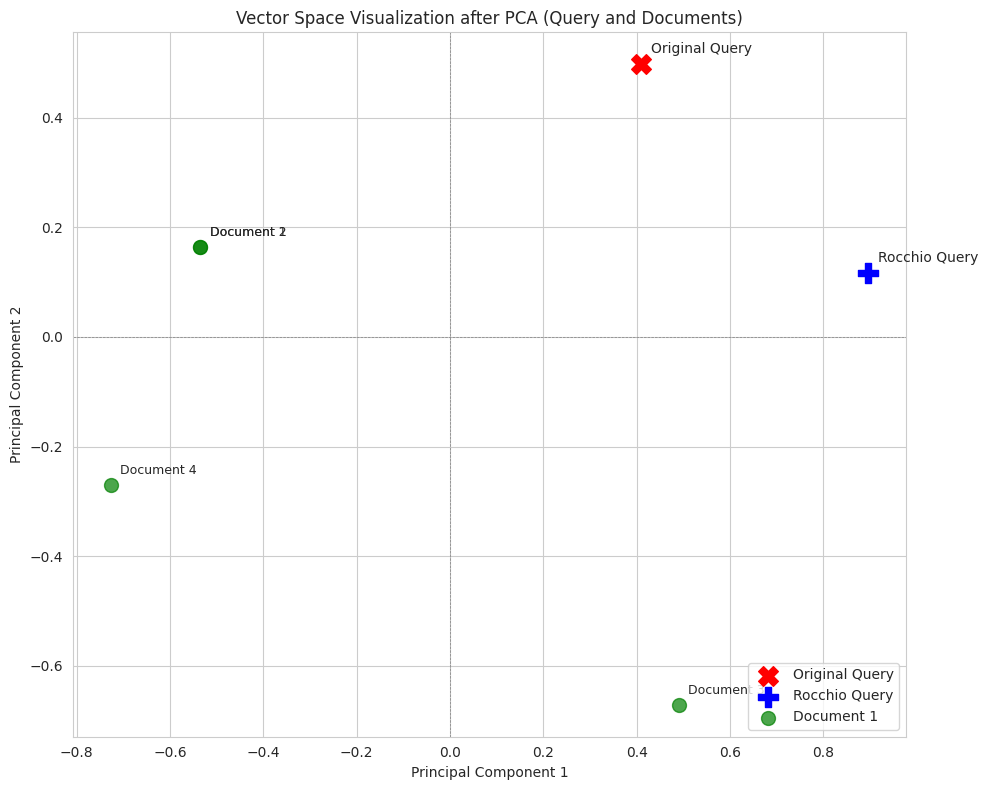

2D scatter plot generated successfully, showing query movement after Rocchio feedback.


In [ ]:
print("Generating 2D scatter plot...")

# Create labels for each point
labels = [
    "Original Query",
    "Rocchio Query"
] + [f"Document {i+1}" for i in range(len(documents))]

plt.figure(figsize=(10, 8))

# Plot Original Query
plt.scatter(
    reduced_vectors[0, 0],
    reduced_vectors[0, 1],
    color='red',
    marker='X',
    s=200,
    label=labels[0],
    zorder=5 # Ensure it's on top
)
plt.annotate(
    labels[0],
    (reduced_vectors[0, 0] + 0.02, reduced_vectors[0, 1] + 0.02),
    fontsize=10
)

# Plot Rocchio Query
plt.scatter(
    reduced_vectors[1, 0],
    reduced_vectors[1, 1],
    color='blue',
    marker='P',
    s=200,
    label=labels[1],
    zorder=5
)
plt.annotate(
    labels[1],
    (reduced_vectors[1, 0] + 0.02, reduced_vectors[1, 1] + 0.02),
    fontsize=10
)

# Plot Document vectors
for i in range(len(documents)):
    plt.scatter(
        reduced_vectors[i + 2, 0],
        reduced_vectors[i + 2, 1],
        color='green',
        marker='o',
        s=100,
        label=labels[i + 2] if i == 0 else "_nolegend_", # Label only once for legend
        alpha=0.7
    )
    plt.annotate(
        labels[i + 2],
        (reduced_vectors[i + 2, 0] + 0.02, reduced_vectors[i + 2, 1] + 0.02),
        fontsize=9
    )

plt.title('Vector Space Visualization after PCA (Query and Documents)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='lower right')
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print("2D scatter plot generated successfully, showing query movement after Rocchio feedback.")

## Final Task

### Subtask:
Review the 2D plot and discuss the insights gained regarding the Rocchio algorithm's effect on query and document positions.


## Summary:

### Q&A
The 2D plot effectively illustrates the impact of the Rocchio algorithm by showing the "Original Query" vector and the "Rocchio Query" vector as distinct points in the reduced 2D space, alongside the document vectors. The visual representation clearly demonstrates the movement or shift of the query vector in the vector space after applying relevance feedback using the Rocchio algorithm, allowing for an intuitive understanding of how the query is refined relative to the documents.

### Data Analysis Key Findings
*   The original query vector, the Rocchio-updated query vector, and the TF-IDF vectors of all four documents were successfully combined into a single matrix of shape (6, 14), representing 6 vectors (1 original query, 1 Rocchio query, 4 documents) each with 14 features.
*   Principal Component Analysis (PCA) successfully reduced the dimensionality of the combined vectors from 14 features to 2 principal components, resulting in a `reduced_vectors` matrix of shape (6, 2).
*   A 2D scatter plot was generated, visually representing the original query (red 'X' marker), the Rocchio-updated query (blue 'P' marker), and the document vectors (green 'o' markers). Each point was annotated with its respective label.
*   The plot distinctly shows the original query and the Rocchio-updated query as separate points, providing a clear visualization of the query's movement in the vector space due to the Rocchio relevance feedback process.

### Insights or Next Steps
*   The visualization confirms that the Rocchio algorithm indeed modifies the query vector, moving it to a new position in the vector space. Further analysis could quantify the magnitude and direction of this shift and its proximity to relevant documents (if known).
*   This plot can be used to intuitively explain the concept of relevance feedback and query expansion in information retrieval. Future work could involve plotting the centroid of relevant and non-relevant documents to further understand the Rocchio query's adjustment.
